Device utilisé : cuda
✅ Poids chargés avec succès.

📂 Classe : 065_larvae_Crustacea
🖼️ Image : 2090.jpg
🎭 Masque : Non trouvé ❌


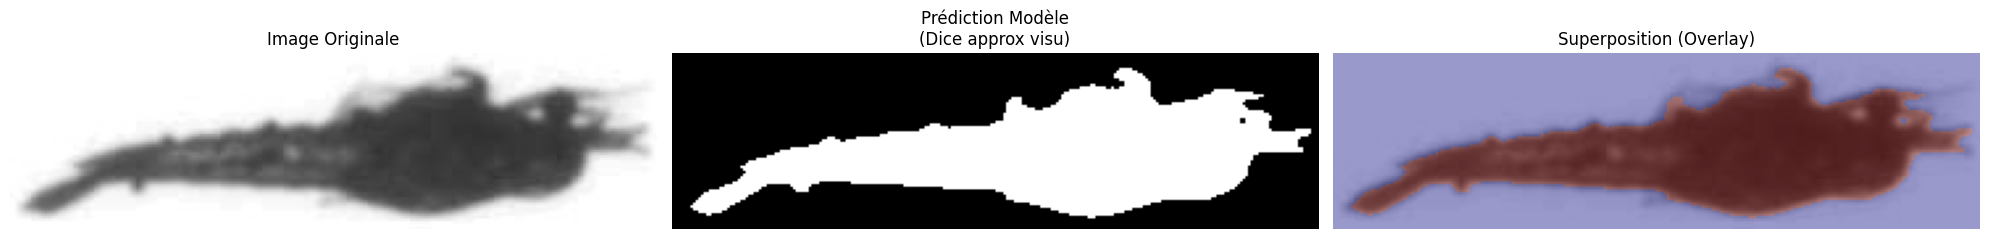

In [ ]:
# --- CELLULE 1 : IMPORTS & CONFIGURATION ---
import os
import random
import glob
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ---------------- CONFIGURATION À ADAPTER ----------------
# Chemin vers tes données d'entraînement
DATASET_ROOT = r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\data\original_dataset\train" 

# Chemin vers ton modèle entraîné (.pt)
MODEL_PATH = r"C:\Users\223120964.HCAD\OneDrive - GEHealthCare\Desktop\transfer_and_active_learning_plankton_segmentation\logs\Unet_12\best_model.pt" # <--- Vérifie ce chemin

# Paramètres du modèle (DOIVENT ÊTRE IDENTIQUES À L'ENTRAÎNEMENT)
MODEL_ARCH = "Unet"
BACKBONE = "resnet34"
IMG_SIZE = 352
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Import de tes modèles (Assure-toi que torchtmpl est accessible)
try:
    from torchtmpl.models.seg_models import DeepLabV3Plus, Unet, DeepLabV3, UnetPlusPlus
except ImportError:
    print("⚠️ ERREUR : Impossible d'importer 'torchtmpl'. Vérifie que tu es dans le bon dossier ou que le package est installé.")

# Mapping des architectures
MODEL_MAP = {
    "Unet": Unet,
    "DeepLabV3": DeepLabV3,
    "DeepLabV3Plus": DeepLabV3Plus,
    "UnetPlusPlus": UnetPlusPlus
}

print(f"Device utilisé : {DEVICE}")


# --- CELLULE 2 : FONCTIONS DE CHARGEMENT ---

def load_inference_model(path, arch, backbone, device):
    """Charge le modèle en mode évaluation."""
    if arch not in MODEL_MAP:
        raise ValueError(f"Architecture {arch} inconnue.")
    
    # Init architecture
    cfg = {"backbone": backbone, "pretrained": False}
    model = MODEL_MAP[arch](cfg, (3, IMG_SIZE, IMG_SIZE), 1) # 1 classe
    
    # Load weights
    if not os.path.exists(path):
        raise FileNotFoundError(f"Modèle introuvable ici : {path}")
        
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint
    
    try:
        model.load_state_dict(state_dict)
        print("✅ Poids chargés avec succès.")
    except Exception as e:
        print(f"⚠️ Erreur chargement strict, tentative en loose mode... {e}")
        model.load_state_dict(state_dict, strict=False)
        
    model.to(device)
    model.eval()
    return model

def get_random_sample(root_dir):
    """
    Parcourt les sous-dossiers (classes) et tire une image au hasard.
    Tente de deviner le chemin du masque.
    """
    # Liste toutes les classes (sous-dossiers)
    classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    if not classes:
        # Cas où les images sont directement dans root_dir
        print("Pas de sous-dossiers 'classes' trouvés, recherche directe...")
        image_list = glob.glob(os.path.join(root_dir, "*.jpg")) + glob.glob(os.path.join(root_dir, "*.png"))
        class_name = "Racine"
    else:
        # Choix d'une classe au hasard
        class_name = random.choice(classes)
        class_path = os.path.join(root_dir, class_name)
        image_list = glob.glob(os.path.join(class_path, "*.jpg")) + glob.glob(os.path.join(class_path, "*.png"))
    
    if not image_list:
        raise FileNotFoundError(f"Aucune image trouvée dans {class_name}")

    img_path = random.choice(image_list)
    
    # --- TENTATIVE DE TROUVER LE MASQUE (À ADAPTER SELON TA STRUCTURE) ---
    # Hypothèse courante : dossier parallèle 'masks' ou suffixe '_mask'
    # Ici, j'assume une structure simple, sinon on renvoie None
    mask_path = None
    
    # Exemple 1 : data/train/images/img.jpg -> data/train/masks/img.png
    potential_mask = img_path.replace("images", "masks").replace(".jpg", ".png")
    if os.path.exists(potential_mask):
        mask_path = potential_mask
    
    # Exemple 2 : Si tes masques sont dans le même dossier
    potential_mask_2 = os.path.splitext(img_path)[0] + "_mask.png"
    if os.path.exists(potential_mask_2):
        mask_path = potential_mask_2

    return img_path, mask_path, class_name


# --- CELLULE 3 : PRÉDICTION ET VISUALISATION ---

def predict_and_show():
    # 1. Charger le modèle (une seule fois si possible, mais ici on le fait pour l'exemple)
    model = load_inference_model(MODEL_PATH, MODEL_ARCH, BACKBONE, DEVICE)
    
    # 2. Récupérer une image
    img_path, mask_path, class_name = get_random_sample(DATASET_ROOT)
    print(f"\n📂 Classe : {class_name}")
    print(f"🖼️ Image : {os.path.basename(img_path)}")
    print(f"🎭 Masque : {'Trouvé ✅' if mask_path else 'Non trouvé ❌'}")

    # 3. Prétraitement
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    h_orig, w_orig = original_img.shape[:2]

    # Pipeline identique à l'entraînement
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Resize pour le modèle
    img_resized = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)

    # 4. Inférence
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)
        # Threshold 0.5
        pred_mask_small = (probs > 0.5).squeeze().cpu().numpy().astype(np.uint8)

    # 5. Redimensionner le masque prédit à la taille originale
    pred_mask = cv2.resize(pred_mask_small, (w_orig, h_orig), interpolation=cv2.INTER_NEAREST)

    # 6. Chargement Masque Vérité Terrain (si dispo)
    gt_mask = None
    if mask_path:
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Binarisation de sécurité
        if gt_mask is not None:
            _, gt_mask = cv2.threshold(gt_mask, 127, 1, cv2.THRESH_BINARY)

    # 7. AFFICHAGE
    fig, axs = plt.subplots(1, 4 if gt_mask is not None else 3, figsize=(20, 6))

    # Image Originale
    axs[0].imshow(original_img)
    axs[0].set_title("Image Originale")
    axs[0].axis("off")

    # Vérité Terrain
    idx = 1
    if gt_mask is not None:
        axs[idx].imshow(gt_mask, cmap='gray')
        axs[idx].set_title("Vérité Terrain (Ground Truth)")
        axs[idx].axis("off")
        idx += 1

    # Prédiction
    axs[idx].imshow(pred_mask, cmap='gray')
    axs[idx].set_title(f"Prédiction Modèle\n(Dice approx visu)")
    axs[idx].axis("off")
    idx += 1

    # Overlay (Superposition)
    axs[idx].imshow(original_img)
    axs[idx].imshow(pred_mask, alpha=0.4, cmap='jet') # Le masque en transparence
    axs[idx].set_title("Superposition (Overlay)")
    axs[idx].axis("off")

    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
predict_and_show()
